In [3]:
!pip install uproot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.8/329.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.6/593.6 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.5 MB/s eta 0:00:00


In [4]:
import uproot
import awkward as ak

In [5]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from pathlib import Path
import h5py

### set I/O path
data_dir = Path.cwd().parent.joinpath('data')
root_dir = data_dir.joinpath('root')
h5_dir = data_dir.joinpath('hdf5')
h5_dir.mkdir(parents=True, exist_ok=True)

root_train_path = root_dir.joinpath('train_50k.root')
root_test_path = root_dir.joinpath('test_40k.root')
h5_train_path = h5_dir.joinpath('train_small.h5')
h5_test_path = h5_dir.joinpath('test_small.h5')

In [7]:
f = uproot.open(root_train_path)
f['particle_mctruth_tree'].arrays('_part_v._pdg', entry_stop=1)['_part_v._pdg']

<Array [[11]] type='1 * var * int32'>

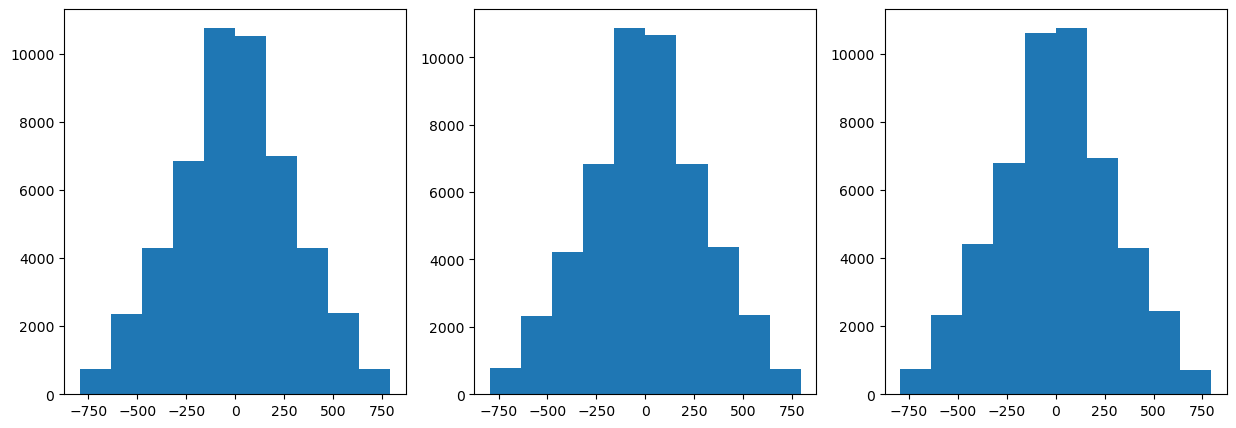

In [19]:
px = f['particle_mctruth_tree'].arrays('_part_v._px', entry_stop=50000)['_part_v._px']
py = f['particle_mctruth_tree'].arrays('_part_v._py', entry_stop=50000)['_part_v._py']
pz = f['particle_mctruth_tree'].arrays('_part_v._pz', entry_stop=50000)['_part_v._pz']
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].hist(px)
axs[1].hist(py)
axs[2].hist(pz)
plt.show()

In [5]:
# look-up table
pdgId2vec = {}
pdgId2vec[11] = np.array([1,0,0,0,0], dtype=float)
pdgId2vec[13] = np.array([0,1,0,0,0], dtype=float)
pdgId2vec[22] = np.array([0,0,1,0,0], dtype=float)
pdgId2vec[211] = np.array([0,0,0,1,0], dtype=float)
pdgId2vec[2212] = np.array([0,0,0,0,1], dtype=float)

In [6]:
def root2npy(fpath, N, start=0, interval=1000):
    intv = interval
    
    f = uproot.open(fpath)
    result_img, result_target = [], []
    
    for i in tqdm(range(int(N/intv))):
        entry_start = start+i*intv
        entry_stop = entry_start+intv
        ak_img = f["image2d_data_tree"].arrays("_image_v._img", entry_start=entry_start, entry_stop=entry_stop)["_image_v._img"]
        ak_target = f['particle_mctruth_tree'].arrays('_part_v._pdg', entry_start=entry_start, entry_stop=entry_stop)['_part_v._pdg']
        
        mask = ak.count(ak_img, 1)==3
        mask = ak.all(mask, -1)
        ak_img = ak_img[mask]
        ak_target = ak_target[mask]
        
        np_img = ak.to_numpy(ak_img)
        np_img = np_img.reshape(-1, 3, 256, 256)
        np_target = ak.to_numpy(ak_target).reshape(-1)
        np_target = np.array([pdgId2vec[pdgId] for pdgId in np_target], dtype=float)
        
        result_img.append(np_img)
        result_target.append(np_target)
    
    result_img = np.concatenate(result_img, axis=0)
    result_target = np.concatenate(result_target, axis=0)
    
    return result_img, result_target

In [7]:
# test = root2npy(root_train_path, N=2000, start=0, interval=1000)


In [8]:
def npy2h5(h5, N, x_name, x_npy, y_name, y_npy):
    with h5py.File(h5, 'a') as hf:
        if x_name not in hf.keys():
            hf.create_dataset(x_name, (N, 3, 256, 256), maxshape=(None,3,256,256), dtype='f', chunks=True)
            hf[x_name][-x_npy.shape[0]:] = x_npy
        else:
            hf[x_name].resize((hf[x_name].shape[0] + x_npy.shape[0]), axis = 0)
            hf[x_name][-x_npy.shape[0]:] = x_npy
        
        if y_name not in hf.keys():
            hf.create_dataset(y_name, (N,5), maxshape=(None,5), dtype='f', chunks=True)
            hf[y_name][-y_npy.shape[0]:] = y_npy
        else:
            hf[y_name].resize((hf[y_name].shape[0] + y_npy.shape[0]), axis = 0)
            hf[y_name][-y_npy.shape[0]:] = y_npy
    return

In [9]:
Path.unlink(h5_train_path, missing_ok=True)
for i in range(5):
    interval = 1000
    start = i*10000
    X, y = root2npy(root_train_path, N=interval, start=start, interval=100)
    npy2h5(h5_train_path, interval, 'X_train', X, 'y_train', y)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [25:09<00:00, 150.96s/it]


In [10]:
Path.unlink(h5_test_path, missing_ok=True)
for i in range(4):
    interval = 1000
    start = i*10000
    X, y = root2npy(root_test_path, N=interval, start=start, interval=100)
    npy2h5(h5_test_path, interval, 'X_test', X, 'y_test', y)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [17:35<00:00, 105.54s/it]
